Epoch 1: Recon = 1867.38, KL = 115.45, Beta = 0.10
Epoch 2: Recon = 1776.18, KL = 151.46, Beta = 0.10
Epoch 3: Recon = 1756.56, KL = 157.26, Beta = 0.10
Epoch 4: Recon = 1747.12, KL = 161.50, Beta = 0.10
Epoch 5: Recon = 1741.44, KL = 165.41, Beta = 0.10
Epoch 6: Recon = 1737.59, KL = 169.37, Beta = 0.10
Epoch 7: Recon = 1734.37, KL = 172.19, Beta = 0.10
Epoch 8: Recon = 1731.98, KL = 175.44, Beta = 0.10
Epoch 9: Recon = 1729.99, KL = 178.17, Beta = 0.10
Epoch 10: Recon = 1728.28, KL = 180.62, Beta = 0.10
Epoch 11: Recon = 1726.89, KL = 183.26, Beta = 0.10
Epoch 12: Recon = 1725.90, KL = 185.78, Beta = 0.10
Epoch 13: Recon = 1724.82, KL = 187.77, Beta = 0.10
Epoch 14: Recon = 1723.76, KL = 189.53, Beta = 0.10
Epoch 15: Recon = 1723.04, KL = 190.94, Beta = 0.10
Epoch 16: Recon = 1722.30, KL = 192.44, Beta = 0.10
Epoch 17: Recon = 1722.01, KL = 193.60, Beta = 0.10
Epoch 18: Recon = 1721.24, KL = 195.15, Beta = 0.10
Epoch 19: Recon = 1720.40, KL = 196.59, Beta = 0.10
Epoch 20: Recon = 172

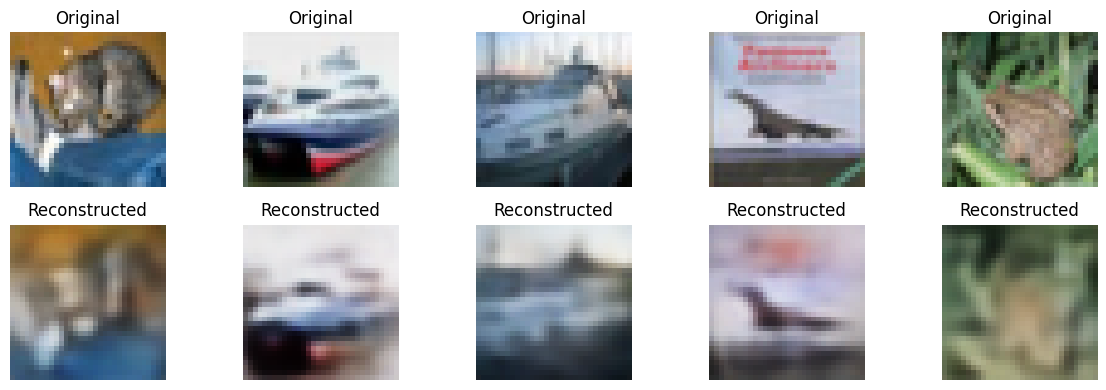

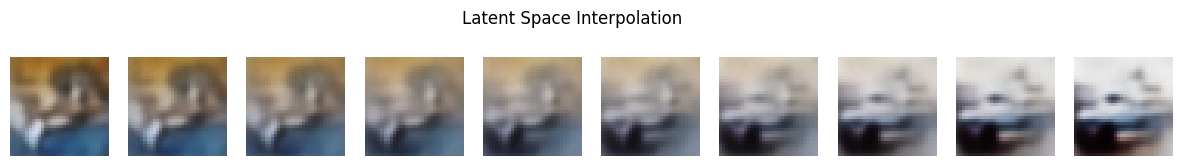

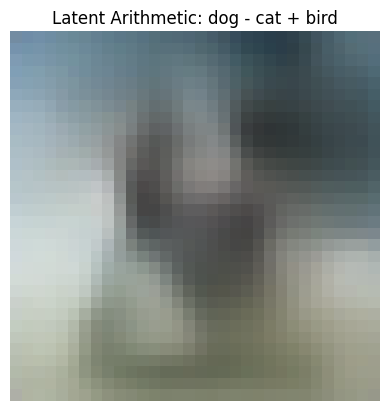

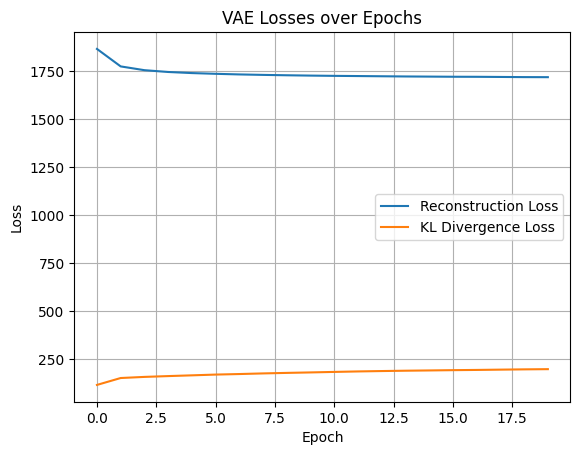

SSIM: 0.7398, PSNR: 22.62, MAE: 0.0565, MSE: 0.0057
[AE] Epoch 1, Loss: 0.0173
[AE] Epoch 2, Loss: 0.0066
[AE] Epoch 3, Loss: 0.0047
[AE] Epoch 4, Loss: 0.0040
[AE] Epoch 5, Loss: 0.0035


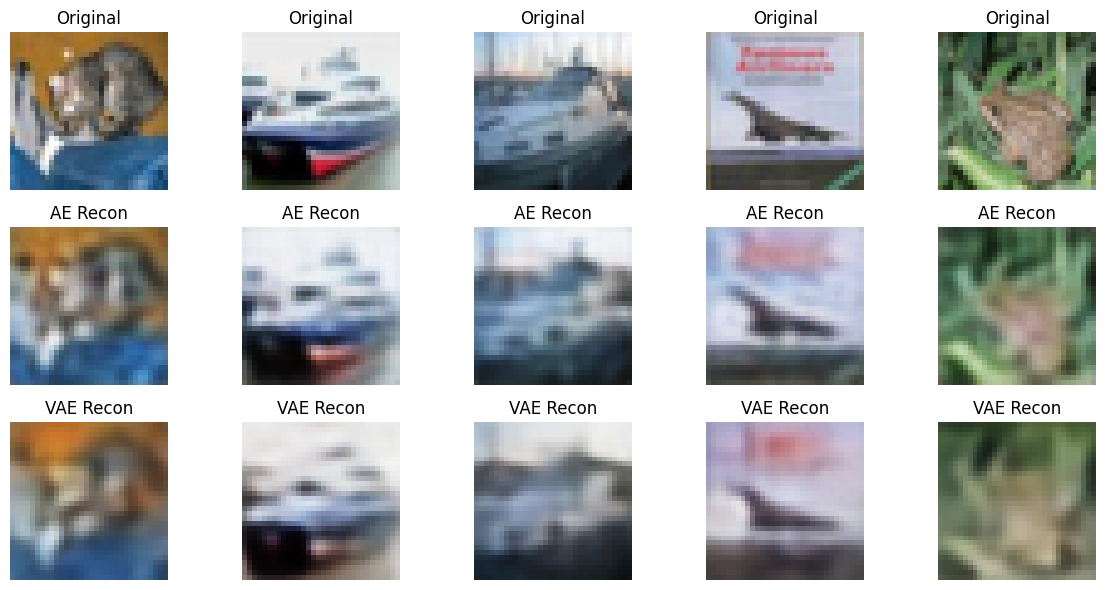

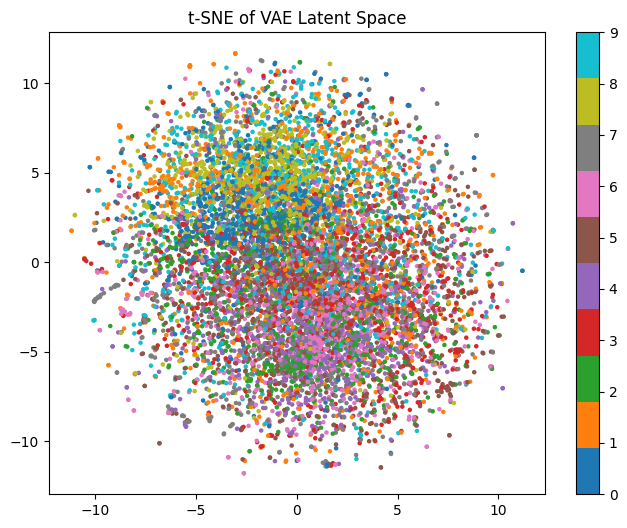

AE:   SSIM: 0.8517, PSNR: 24.92
VAE:  SSIM: 0.7462, PSNR: 22.70


In [ ]:
# Variational Autoencoder (VAE) - CS671 Assignment Part-II (Complete with All Results)

# === Import Required Libraries ===
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from collections import defaultdict

# === Set Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load CIFAR-10 Dataset ===
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# === Define the Reparameterization Trick ===
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# === Define the VAE Model ===
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*4*4, 256)
        self.fc_logvar = nn.Linear(128*4*4, 256)
        self.fc_decode = nn.Linear(256, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        z = reparameterize(mu, logvar)
        decoded = self.fc_decode(z).view(-1, 128, 4, 4)
        return self.decoder(decoded), mu, logvar

# === Define the BCE + KL Divergence Loss Function ===
def vae_loss(recon_x, x, mu, logvar, beta):
    recon = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

# === Train the VAE ===
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 20
recon_loss_list, kl_loss_list = [], []

for epoch in range(num_epochs):
    beta = 0.1
    vae.train()
    total_recon, total_kl = 0, 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        loss, recon_l, kl_l = vae_loss(recon, imgs, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += recon_l.item()
        total_kl += kl_l.item()

    recon_loss_list.append(total_recon / len(trainloader.dataset))
    kl_loss_list.append(total_kl / len(trainloader.dataset))
    print(f"Epoch {epoch+1}: Recon = {recon_loss_list[-1]:.2f}, KL = {kl_loss_list[-1]:.2f}, Beta = {beta:.2f}")

# === Visualize Reconstructions ===
vae.eval()
with torch.no_grad():
    for imgs, _ in testloader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        break

fig, axs = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    axs[0, i].imshow(np.transpose(imgs[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")
    axs[1, i].imshow(np.transpose(recon[i].cpu(), (1, 2, 0)))
    axs[1, i].axis('off')
    axs[1, i].set_title("Reconstructed")
plt.tight_layout()
plt.show()

# === Interpolation Between Two Latent Points ===
z1 = reparameterize(mu[0:1], logvar[0:1])
z2 = reparameterize(mu[1:2], logvar[1:2])
z_vals = torch.stack([(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, 10)]).to(device)
decoded = vae.decoder(vae.fc_decode(z_vals).view(-1, 128, 4, 4)).cpu()

plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # Detach the tensor and convert to NumPy array before plotting
    plt.imshow(np.transpose(decoded[i].detach().numpy(), (1, 2, 0)))
    plt.axis("off")
plt.suptitle("Latent Space Interpolation")
plt.show()


# === Latent Arithmetic: dog - cat + bird ===
idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}
class_means = defaultdict(list)
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        _, mu, _ = vae(x)
        for i in range(x.size(0)):
            label = idx_to_class[y[i].item()]
            if label in ['dog', 'cat', 'bird'] and len(class_means[label]) < 10:
                class_means[label].append(mu[i].cpu())
        if all(len(class_means[c]) >= 10 for c in ['dog', 'cat', 'bird']):
            break
z = torch.stack(class_means['dog']).mean(0) - torch.stack(class_means['cat']).mean(0) + torch.stack(class_means['bird']).mean(0)
z = z.to(device)
with torch.no_grad():
    result = vae.decoder(vae.fc_decode(z.unsqueeze(0)).view(-1, 128, 4, 4))
plt.imshow(np.transpose(result[0].cpu(), (1, 2, 0)))
plt.axis('off')
plt.title("Latent Arithmetic: dog - cat + bird")
plt.show()

# === Plot KL and Reconstruction Loss ===
plt.plot(recon_loss_list, label='Reconstruction Loss')
plt.plot(kl_loss_list, label='KL Divergence Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# === Evaluation Metrics ===
orig = imgs[:10].permute(0, 2, 3, 1).cpu().numpy()
recon = recon[:10].permute(0, 2, 3, 1).cpu().numpy()
ssim_scores = [ssim(orig[i], recon[i], channel_axis=-1, data_range=1.0) for i in range(10)]
psnr_scores = [psnr(orig[i], recon[i], data_range=1.0) for i in range(10)]
mae = np.abs(orig - recon).mean()
mse = np.square(orig - recon).mean()
print(f"SSIM: {np.mean(ssim_scores):.4f}, PSNR: {np.mean(psnr_scores):.2f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

# === Compare VAE vs. AE Reconstructions ===

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

ae = AE().to(device)
ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()

for epoch in range(5):
    ae.train()
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        output = ae(imgs)
        loss = ae_criterion(output, imgs)
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item()
    print(f"[AE] Epoch {epoch+1}, Loss: {total_loss / len(trainloader):.4f}")

ae.eval()
with torch.no_grad():
    for imgs, _ in testloader:
        imgs = imgs.to(device)
        ae_recon = ae(imgs)
        vae_recon, _, _ = vae(imgs)
        break

fig, axs = plt.subplots(3, 5, figsize=(12, 6))
for i in range(5):
    axs[0, i].imshow(np.transpose(imgs[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[0, i].set_title("Original")
    axs[0, i].axis("off")
    axs[1, i].imshow(np.transpose(ae_recon[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[1, i].set_title("AE Recon")
    axs[1, i].axis("off")
    axs[2, i].imshow(np.transpose(vae_recon[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[2, i].set_title("VAE Recon")
    axs[2, i].axis("off")
plt.tight_layout()
plt.show()

# === t-SNE Latent Space Visualization ===
latent_vecs, labels_all = [], []
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        _, mu, _ = vae(x)
        latent_vecs.append(mu.cpu())
        labels_all.append(y)
X_latent = torch.cat(latent_vecs).numpy()
y_latent = torch.cat(labels_all).numpy()
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_latent)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_latent, cmap='tab10', s=5)
plt.colorbar()
plt.title("t-SNE of VAE Latent Space")
plt.show()
# AE vs VAE Metrics Comparison
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

ae_img = ae_recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
vae_img = vae_recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
orig_img = imgs[:10].permute(0, 2, 3, 1).detach().cpu().numpy()

ae_ssim = [ssim(orig_img[i], ae_img[i], channel_axis=-1, data_range=1.0) for i in range(10)]
vae_ssim = [ssim(orig_img[i], vae_img[i], channel_axis=-1, data_range=1.0) for i in range(10)]

ae_psnr = [psnr(orig_img[i], ae_img[i], data_range=1.0) for i in range(10)]
vae_psnr = [psnr(orig_img[i], vae_img[i], data_range=1.0) for i in range(10)]

print(f"AE:   SSIM: {np.mean(ae_ssim):.4f}, PSNR: {np.mean(ae_psnr):.2f}")
print(f"VAE:  SSIM: {np.mean(vae_ssim):.4f}, PSNR: {np.mean(vae_psnr):.2f}")

##Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from collections import defaultdict

##Set Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Load CIFAR-10 Dataset

In [ ]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


##Define the Reparameterization Trick

In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

##Define the VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*4*4, 256)
        self.fc_logvar = nn.Linear(128*4*4, 256)
        self.fc_decode = nn.Linear(256, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        z = reparameterize(mu, logvar)
        decoded = self.fc_decode(z).view(-1, 128, 4, 4)
        return self.decoder(decoded), mu, logvar

##Define Loss Function (BCE + KL Divergence)

In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta):
    recon = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl


##Train the VAE

In [ ]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 20
recon_loss_list, kl_loss_list = [], []

for epoch in range(num_epochs):
    beta = 0.1
    vae.train()
    total_recon, total_kl = 0, 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        loss, recon_l, kl_l = vae_loss(recon, imgs, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += recon_l.item()
        total_kl += kl_l.item()

    recon_loss_list.append(total_recon / len(trainloader.dataset))
    kl_loss_list.append(total_kl / len(trainloader.dataset))
    print(f"Epoch {epoch+1}: Recon = {recon_loss_list[-1]:.2f}, KL = {kl_loss_list[-1]:.2f}, Beta = {beta:.2f}")

Epoch 1: Recon = 1867.38, KL = 112.65, Beta = 0.10
Epoch 2: Recon = 1779.72, KL = 146.75, Beta = 0.10
Epoch 3: Recon = 1759.22, KL = 152.49, Beta = 0.10
Epoch 4: Recon = 1748.94, KL = 158.14, Beta = 0.10
Epoch 5: Recon = 1742.40, KL = 163.76, Beta = 0.10
Epoch 6: Recon = 1737.88, KL = 168.16, Beta = 0.10
Epoch 7: Recon = 1734.51, KL = 171.39, Beta = 0.10
Epoch 8: Recon = 1731.99, KL = 174.28, Beta = 0.10
Epoch 9: Recon = 1730.07, KL = 176.58, Beta = 0.10
Epoch 10: Recon = 1728.60, KL = 178.97, Beta = 0.10
Epoch 11: Recon = 1727.18, KL = 181.16, Beta = 0.10
Epoch 12: Recon = 1726.08, KL = 183.24, Beta = 0.10
Epoch 13: Recon = 1725.07, KL = 185.43, Beta = 0.10
Epoch 14: Recon = 1724.27, KL = 187.09, Beta = 0.10
Epoch 15: Recon = 1723.79, KL = 188.66, Beta = 0.10
Epoch 16: Recon = 1722.74, KL = 190.28, Beta = 0.10
Epoch 17: Recon = 1722.09, KL = 191.88, Beta = 0.10
Epoch 18: Recon = 1721.50, KL = 193.36, Beta = 0.10
Epoch 19: Recon = 1720.99, KL = 194.77, Beta = 0.10
Epoch 20: Recon = 172

##Visualize VAE Reconstructions

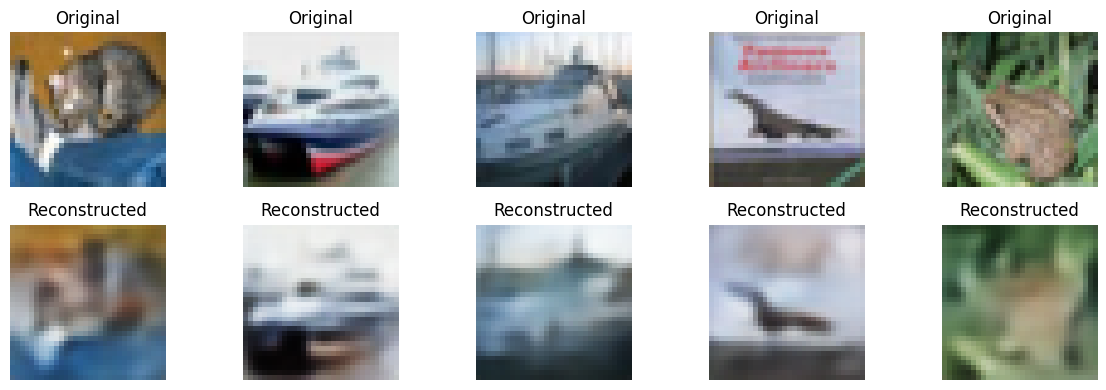

In [ ]:
vae.eval()
with torch.no_grad():
    for imgs, _ in testloader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        break

fig, axs = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    axs[0, i].imshow(np.transpose(imgs[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")
    axs[1, i].imshow(np.transpose(recon[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[1, i].axis('off')
    axs[1, i].set_title("Reconstructed")
plt.tight_layout()
plt.show()

##Interpolation Between Two Latent Points

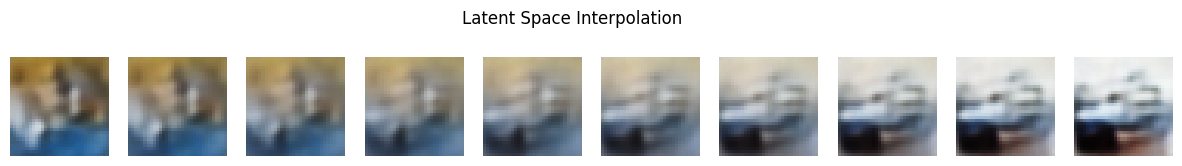

In [ ]:
z1 = reparameterize(mu[0:1], logvar[0:1])
z2 = reparameterize(mu[1:2], logvar[1:2])
z_vals = torch.stack([(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, 10)]).to(device)
decoded = vae.decoder(vae.fc_decode(z_vals).view(-1, 128, 4, 4)).cpu()

plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.transpose(decoded[i].detach().numpy(), (1, 2, 0)))
    plt.axis("off")
plt.suptitle("Latent Space Interpolation")
plt.show()

##Latent Arithmetic: dog - cat + bird

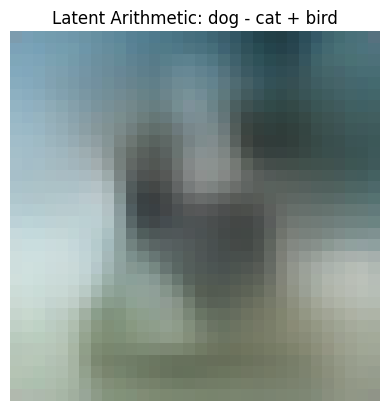

In [ ]:
idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}
class_means = defaultdict(list)
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        _, mu, _ = vae(x)
        for i in range(x.size(0)):
            label = idx_to_class[y[i].item()]
            if label in ['dog', 'cat', 'bird'] and len(class_means[label]) < 10:
                class_means[label].append(mu[i].cpu())
        if all(len(class_means[c]) >= 10 for c in ['dog', 'cat', 'bird']):
            break
z = torch.stack(class_means['dog']).mean(0) - torch.stack(class_means['cat']).mean(0) + torch.stack(class_means['bird']).mean(0)
z = z.to(device)
with torch.no_grad():
    result = vae.decoder(vae.fc_decode(z.unsqueeze(0)).view(-1, 128, 4, 4))
plt.imshow(np.transpose(result[0].detach().cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Latent Arithmetic: dog - cat + bird")
plt.show()

##Plot KL and Reconstruction Loss

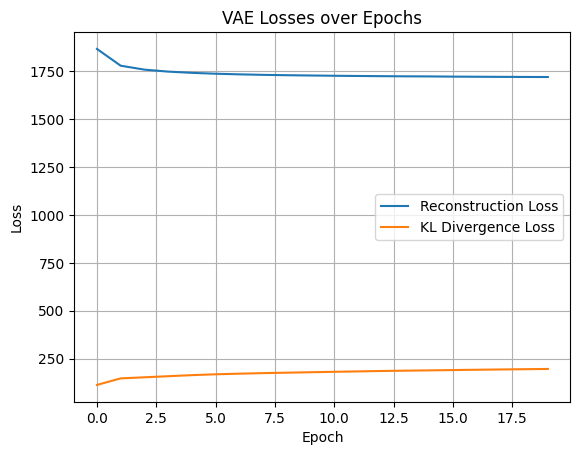

In [ ]:
plt.plot(recon_loss_list, label='Reconstruction Loss')
plt.plot(kl_loss_list, label='KL Divergence Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Losses over Epochs")
plt.legend()
plt.grid(True)
plt.show()

##Evaluation Metrics

In [ ]:
orig = imgs[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
recon = recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
ssim_scores = [ssim(orig[i], recon[i], channel_axis=-1, data_range=1.0) for i in range(10)]
psnr_scores = [psnr(orig[i], recon[i], data_range=1.0) for i in range(10)]
mae = np.abs(orig - recon).mean()
mse = np.square(orig - recon).mean()
print(f"SSIM: {np.mean(ssim_scores):.4f}, PSNR: {np.mean(psnr_scores):.2f}, MAE: {mae:.4f}, MSE: {mse:.4f}")


SSIM: 0.7495, PSNR: 22.93, MAE: 0.0542, MSE: 0.0053


##Compare VAE vs. AE Reconstructions

[AE] Epoch 1, Loss: 0.0162
[AE] Epoch 2, Loss: 0.0069
[AE] Epoch 3, Loss: 0.0053
[AE] Epoch 4, Loss: 0.0041
[AE] Epoch 5, Loss: 0.0036


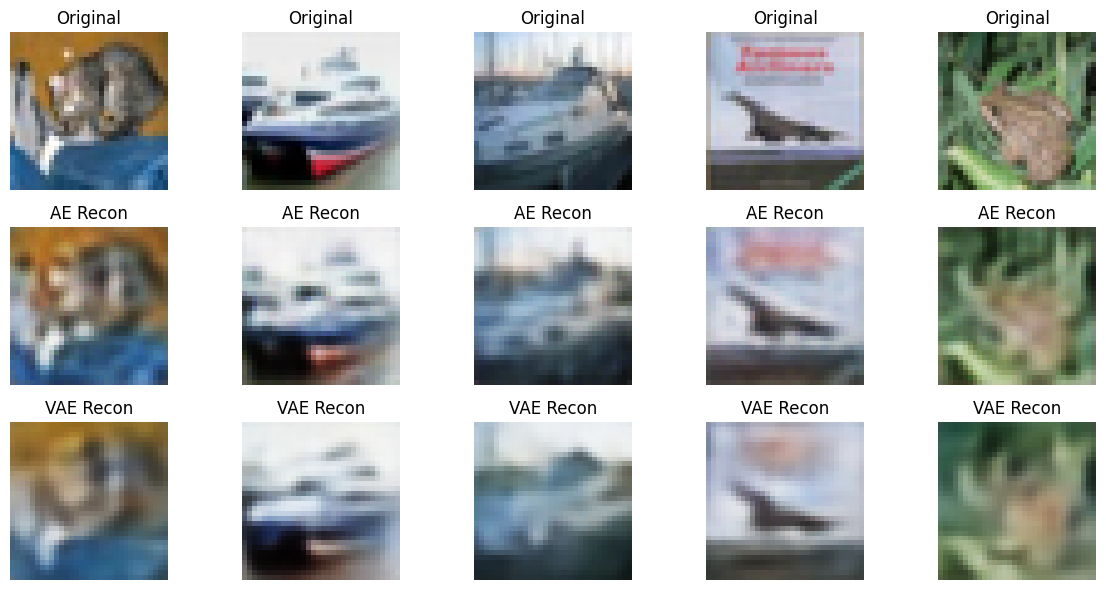

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

ae = AE().to(device)
ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
ae_criterion = nn.MSELoss()

for epoch in range(5):
    ae.train()
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        output = ae(imgs)
        loss = ae_criterion(output, imgs)
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        total_loss += loss.item()
    print(f"[AE] Epoch {epoch+1}, Loss: {total_loss / len(trainloader):.4f}")

ae.eval()
with torch.no_grad():
    for imgs, _ in testloader:
        imgs = imgs.to(device)
        ae_recon = ae(imgs)
        vae_recon, _, _ = vae(imgs)
        break

fig, axs = plt.subplots(3, 5, figsize=(12, 6))
for i in range(5):
    axs[0, i].imshow(np.transpose(imgs[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[0, i].set_title("Original")
    axs[0, i].axis("off")
    axs[1, i].imshow(np.transpose(ae_recon[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[1, i].set_title("AE Recon")
    axs[1, i].axis("off")
    axs[2, i].imshow(np.transpose(vae_recon[i].detach().cpu().numpy(), (1, 2, 0)))
    axs[2, i].set_title("VAE Recon")
    axs[2, i].axis("off")
plt.tight_layout()
plt.show()

##t-SNE Latent Space Visualization

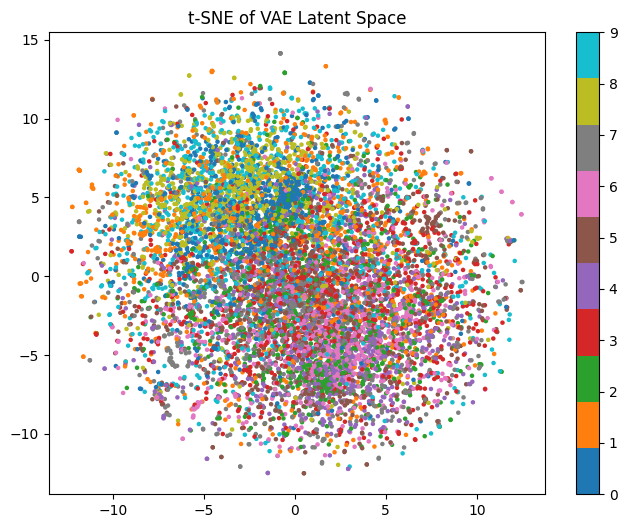

In [ ]:
latent_vecs, labels_all = [], []
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        _, mu, _ = vae(x)
        latent_vecs.append(mu.cpu())
        labels_all.append(y)
X_latent = torch.cat(latent_vecs).numpy()
y_latent = torch.cat(labels_all).numpy()
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_latent)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_latent, cmap='tab10', s=5)
plt.colorbar()
plt.title("t-SNE of VAE Latent Space")
plt.show()


##Quantitative AE vs. VAE Comparison

In [ ]:
ae_img = ae_recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
vae_img = vae_recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
orig_img = imgs[:10].permute(0, 2, 3, 1).detach().cpu().numpy()

ae_ssim = [ssim(orig_img[i], ae_img[i], channel_axis=-1, data_range=1.0) for i in range(10)]
vae_ssim = [ssim(orig_img[i], vae_img[i], channel_axis=-1, data_range=1.0) for i in range(10)]

ae_psnr = [psnr(orig_img[i], ae_img[i], data_range=1.0) for i in range(10)]
vae_psnr = [psnr(orig_img[i], vae_img[i], data_range=1.0) for i in range(10)]

print(f"AE:   SSIM: {np.mean(ae_ssim):.4f}, PSNR: {np.mean(ae_psnr):.2f}")
print(f"VAE:  SSIM: {np.mean(vae_ssim):.4f}, PSNR: {np.mean(vae_psnr):.2f}")
orig = imgs[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
vae_recon[:10].permute(0, 2, 3, 1).detach().cpu().numpy()
ssim_scores = [ssim(orig[i], recon[i], channel_axis=-1, data_range=1.0) for i in range(10)]
psnr_scores = [psnr(orig[i], recon[i], data_range=1.0) for i in range(10)]
mae = np.abs(orig - recon).mean()
mse = np.square(orig - recon).mean()
print(f"SSIM: {np.mean(ssim_scores):.4f}, PSNR: {np.mean(psnr_scores):.2f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

AE:   SSIM: 0.8540, PSNR: 25.26
VAE:  SSIM: 0.7533, PSNR: 22.95
SSIM: 0.7495, PSNR: 22.93, MAE: 0.0542, MSE: 0.0053
